In [10]:
import os
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import optax
import datasets
import models
import samplers
import matplotlib.pyplot as plt
from conv_emergence import compute_entropy as entropy
from experiments import make_key, simulate
from viz_box import position_mean_var, ipr, entropy_sort, mean_sort, var_sort, plot_receptive_fields

In [11]:
config = dict(
    seed=0,
    num_dimensions=40,
    num_hiddens=100,
    init_scale=1.0,
    activation='tanh',
    model_cls=models.SimpleNet,
    optimizer_fn=optax.sgd,
    learning_rate=1.0,
    batch_size=1,
    num_epochs=1000,
    dataset_cls=datasets.SinglePulseDataset,
    xi1=(0.2, 0.25), # (20, 25),
    xi2=(0.05, 0.1), #(5, 10), # (5, 10),
    class_proportion=0.5,
    sampler_cls=samplers.EpochSampler,
    init_fn=models.lecun_normal_init,
    save_=False,
)

#### Let's see how the weights evolve over time.

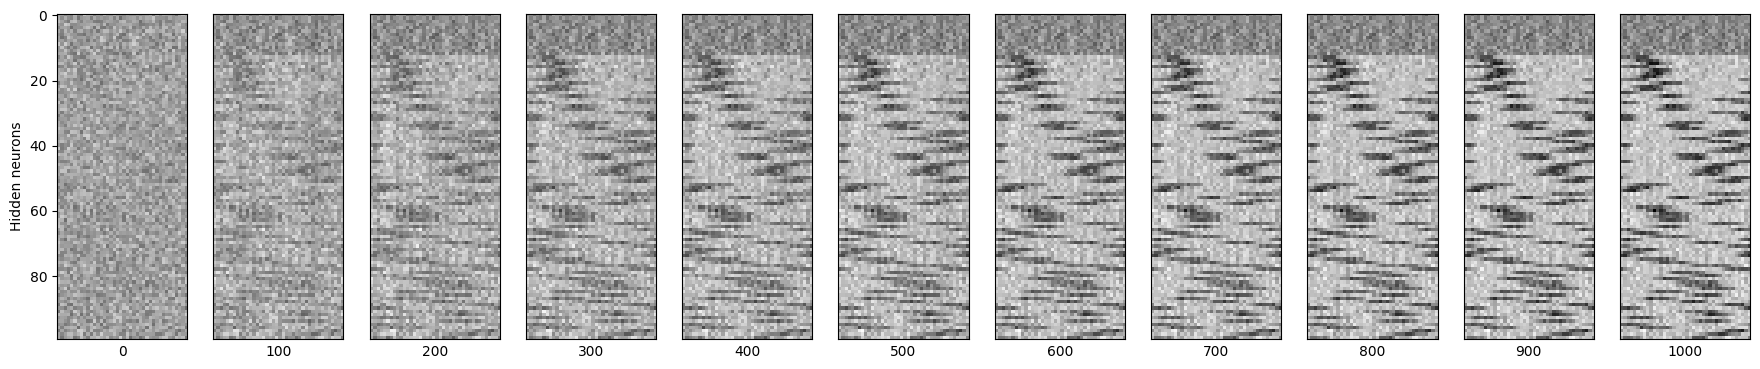

In [12]:
path_key = make_key(**config)
evaluation_interval = 100
weights = np.load(f"results/weights/{path_key}/fc1.npy")
fig, axs = plot_receptive_fields(weights, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)
# fig.savefig(f"results/weights/{path_key}/receptive_fields.png", dpi=300, bbox_inches='tight')

#### Now, let's see how some metrics change over time.

We'll focus on loss, accuracy, IPR, and entropy for now.

In [26]:
metrics = pd.read_csv(f"results/weights/{path_key}/metrics.csv")
loss_ = metrics['loss'].values
accuracy_ = metrics['accuracy'].values
ipr_ = np.stack([ ipr(weight_) for weight_ in weights ])
entropy_ = np.stack([ entropy(weight_) for weight_ in weights ])

It seems like entropy is the more useful than IPR for discriminating between localized and "oscillatory" receptive fields.

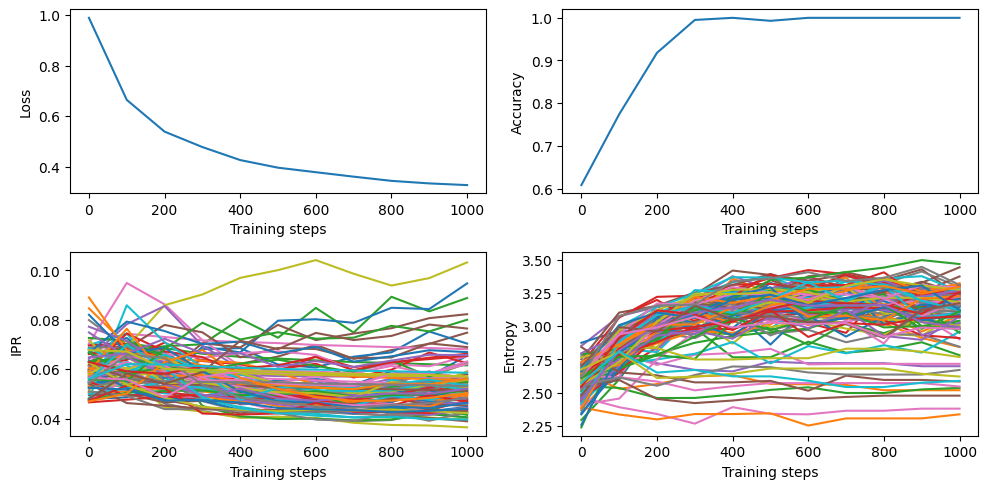

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
for ax, metric, label in zip(axs.flatten(), [loss_, accuracy_, ipr_, entropy_], ['Loss', 'Accuracy', 'IPR', 'Entropy']):
    ax.plot(evaluation_interval * np.arange(len(metric)), metric)
    ax.set_xlabel('Training steps')
    ax.set_ylabel(label)
fig.tight_layout()

#### Now, let's see what the weights actually look like.

That is, which kernel are the localized receptive field learning?

Looks like localized receptive fields have a baseline at 0.5 and drop to nearly -1.0.
The oscillatory receptive fields hover around 0.

This plot (as well the full set of receptive fields above) shows us that all the localized receptive fields have roughly the same bandwidth of about five units.

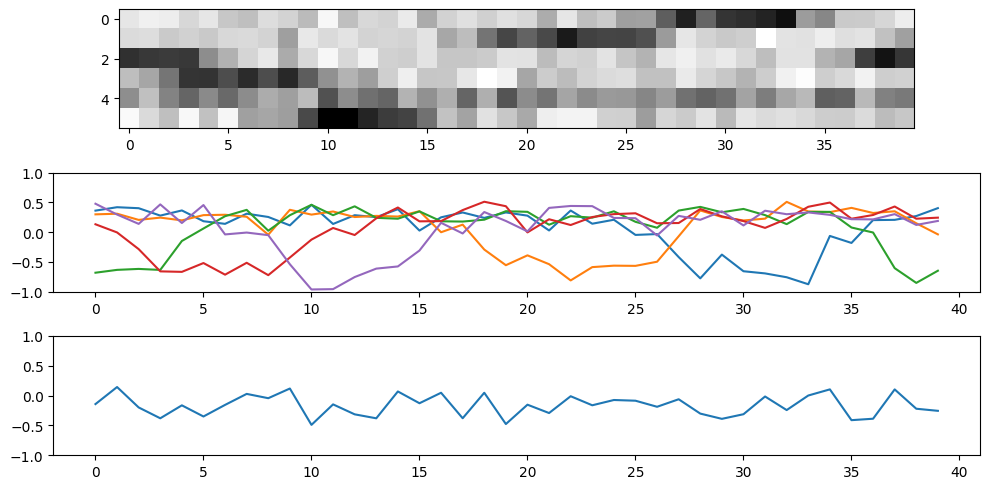

In [61]:
# Let's pick out a few weights to visualize
localized_inds = np.array([0, 1, 2, 3, 5])
oscillatory_inds = np.array([4])
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5))
ax1.imshow(weights[-1][:6], cmap='gray')
ax2.plot(weights[-1][localized_inds].T)
ax2.set_ylim(-1, 1)
ax3.plot(weights[-1][oscillatory_inds].T)
ax3.set_ylim(-1, 1)
fig.tight_layout()

#### Now, let's see how the localized and oscillatory receptive fields evolve over time.

First, we'll visualize each receptive fields at various points in time.
Then, we'll see how the group evolves over time.

We'll see that the localized receptive fields' kernels begin to emerge immediately and grow in magnitude continuously and uniformly throughout training.
The oscillatory receptive field barely changes at all during training.
A closer look later (might not be plotted) reveals that oscillatory neurons seem to hover around -0.1 (just eyeballing, not quantitative at all).

This begs the question: What happens if we prune the oscillatory receptive fields?

These graphs also suggest that looking at the largest absolute value of the weights for each neuron will be useful for discriminating localized and oscillatory receptive fields.
I confirm this in the final plot, where we see the largest and mean absolute values grow linearly during training for localized neurons while they are constant for oscillatory neurons.

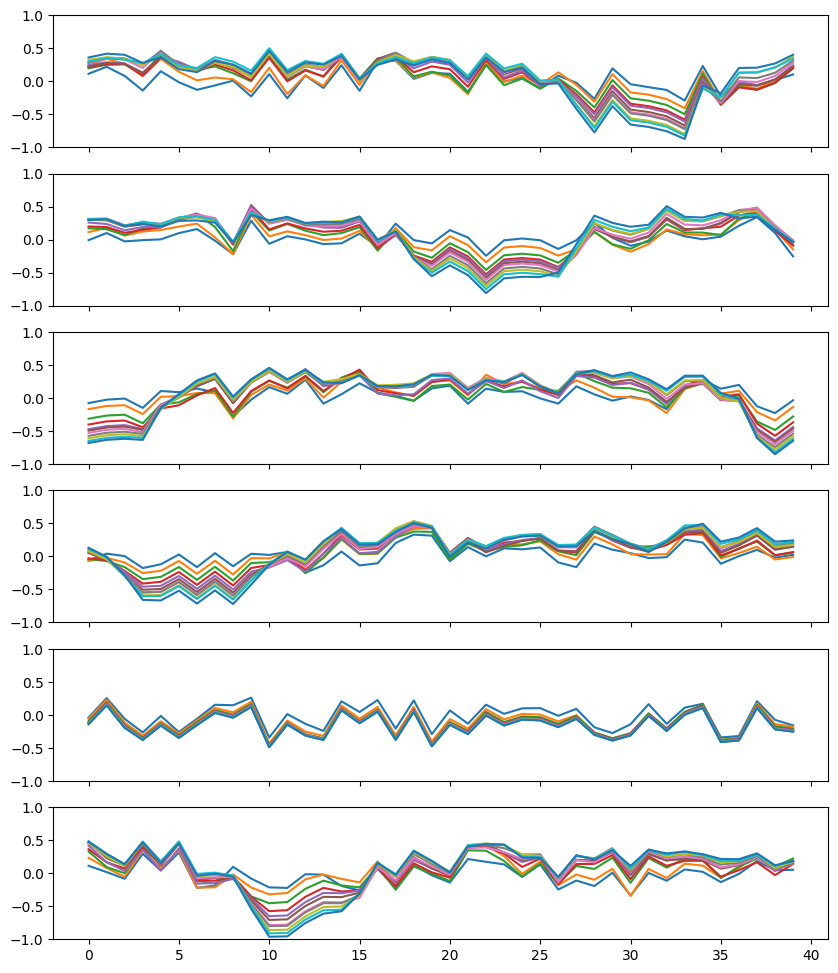

In [89]:
fig, axs = plt.subplots(6, 1, figsize=(10, 12), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(weights[:,i,:].T)
    ax.set_ylim(-1, 1)

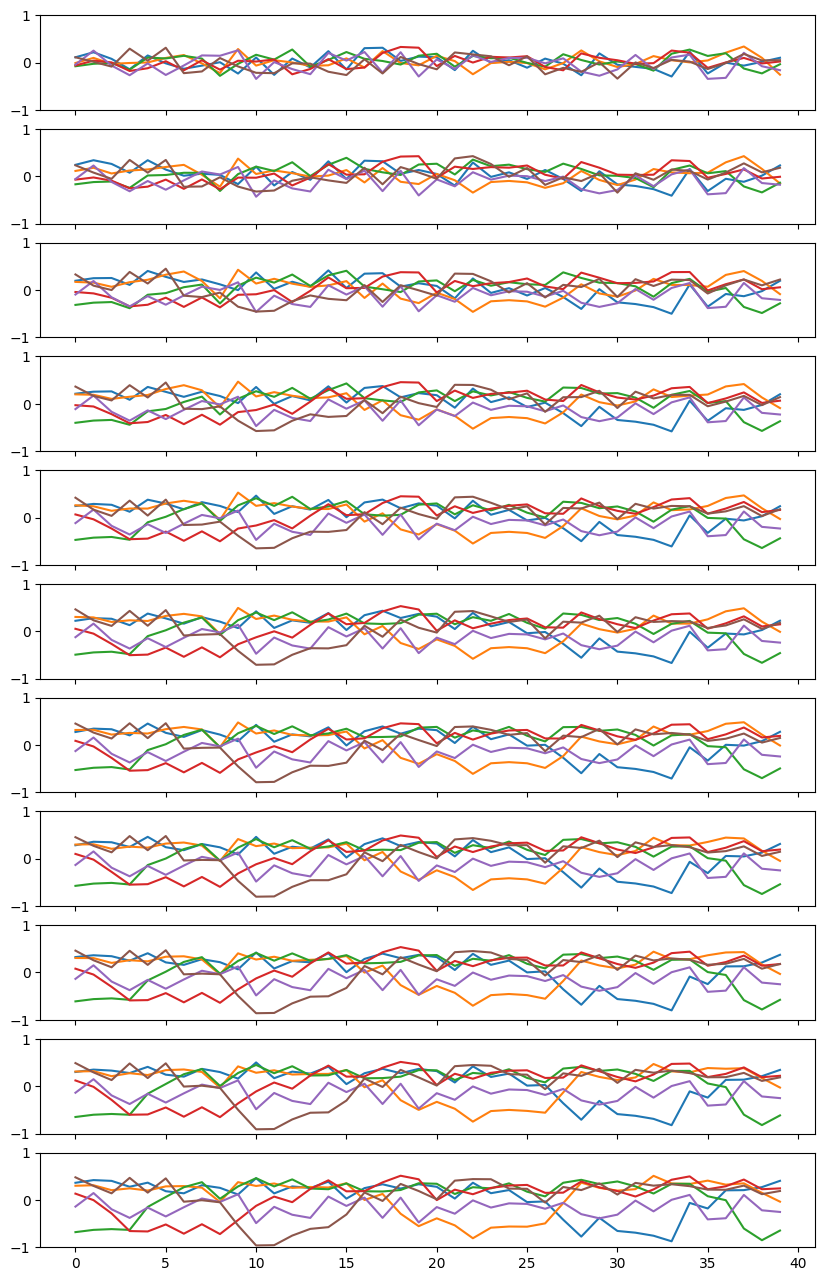

In [90]:
fig, axs = plt.subplots(11, 1, figsize=(10, 16), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(weights[i,:6,:].T)
    ax.set_ylim(-1, 1)

Text(0, 0.5, 'Mean weight magnitude')

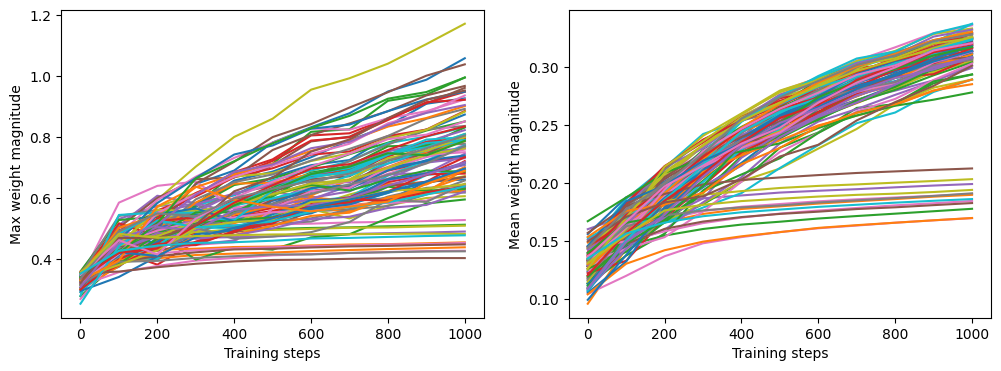

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot( np.arange(11) * evaluation_interval, np.max(np.abs(weights), axis=2) )
ax1.set_xlabel('Training steps')
ax1.set_ylabel('Max weight magnitude')
ax2.plot( np.arange(11) * evaluation_interval, np.mean(np.abs(weights), axis=2) )
ax2.set_xlabel('Training steps')
ax2.set_ylabel('Mean weight magnitude')

#### Pruning oscillatory neurons

Let's see how much behavior changes when we prune the oscillatory neurons.
We'll sort them using the mean weight magnitude, since that's where we seem to get the cleanest separation.

It seems like the oscillatory neurons collectively act as a bias term.
Inspecting their activations, we see that they (seemingly) always output ~1.0 in the hidden layer.
The localized neurons tend to be strongly negative, but are more positive for the positive class (which has longer pulses).

So, the localized neurons must learn to offset the positive bias in prediction from the oscillatory neurons.
Recall that the oscillatory neurons do not change throughout training.
So why do the oscillatory neurons exist at all then?
Why aren't their weights adjusted in addition to those of the localized neurons?
Why do the localized neurons have to learn to correct for them?

In [154]:
localized_mask = np.mean(np.abs(weights[-1]), axis=-1) > 0.25
weights_ = weights[-1]
weights_localized = weights_[localized_mask]

def forward(weight, x, K=100):
    h = np.tanh(weight @ x)
    z = np.sum(h, axis=0) / K
    # z = np.mean(h, axis=0)
    return z

dataset = datasets.SinglePulseDataset(key=jax.random.PRNGKey(0), **config)
x, y = dataset[:1000]

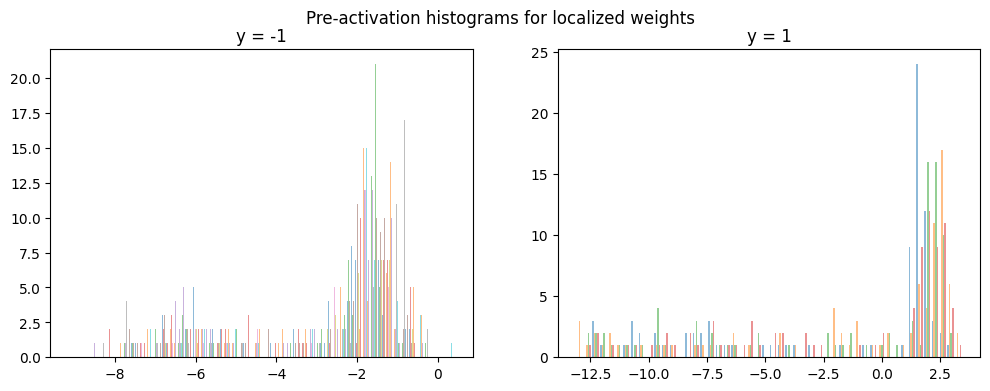

In [172]:
pre_h = weights_[localized_mask] @ x[:20].T
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(pre_h[:,y[:20] == -1].T, bins=50, alpha=0.5, label='y = -1')
ax2.hist(pre_h[:,y[:20] == 1].T, bins=50, alpha=0.5, label='y = 1')
ax1.set_title('y = -1')
ax2.set_title('y = 1')
_ = fig.suptitle('Pre-activation histograms for localized weights')

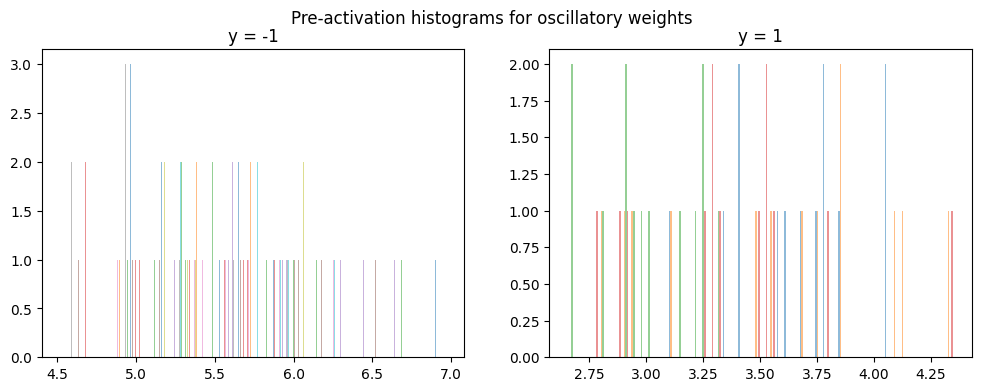

In [175]:
pre_h = weights_[~localized_mask] @ x[:20].T
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(pre_h[:,y[:20] == -1].T, bins=50, alpha=0.5, label='y = -1')
ax2.hist(pre_h[:,y[:20] == 1].T, bins=50, alpha=0.5, label='y = 1')
ax1.set_title('y = -1')
ax2.set_title('y = 1')
_ = fig.suptitle('Pre-activation histograms for oscillatory weights')

We get exactly what we'd expect in the last plot: predictions are off by about 0.13, which corresponds to the 13 oscillatory neurons we've removed that would bias the output up by 13 * 1.0 / 100.

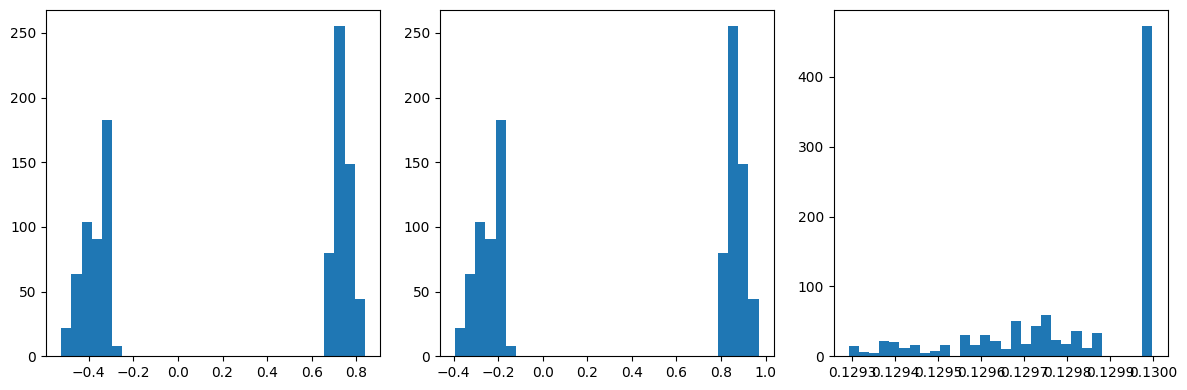

In [176]:
yhat = forward(weights_, x.T)
yhat_pruned = forward(weights_localized, x.T)
delta = yhat - yhat_pruned

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.hist(y - yhat, bins=30)
ax2.hist(y - yhat_pruned, bins=30)
ax3.hist(yhat - yhat_pruned, bins=30)
fig.tight_layout()

#### How stable is the solution?

How much can we perturb the weights away from the solution found above and still recover (roughly) the same weights?

First, we'll shrink it.
Then, we'll see how much Gaussian noise we can add.

In the former case, we'll see that we can basically shrink as far as we want (until we get below machine precision) and the model will just scale the solution back up.

#### Scaling

Using JAX backend: cpu

Using configuration:
{'activation': 'tanh',
 'batch_size': 100,
 'class_proportion': 0.5,
 'dataset_cls': <class 'datasets.single_pulse.SinglePulseDataset'>,
 'gain': None,
 'init_fn': <function <lambda> at 0x157819120>,
 'init_scale': 0.01,
 'learning_rate': 1.0,
 'model_cls': <class 'models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 100,
 'optimizer_fn': <function sgd at 0x15357efc0>,
 'sampler_cls': <class 'samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 42,
 'wandb_': False,
 'xi1': (0.2, 0.25),
 'xi2': (0.05, 0.1)}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 100000
Length of eval dataset: 2000
Length of train sampler: 100000
Length of eval sampler: 2000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[100,40](numpy),
    bias=None,
    in_features=40,
    out_features=100,
    use_bias=False
  ),
  act=<wrapped function <lambda>>
)

Starting evaluation...
Completed evaluation over 20

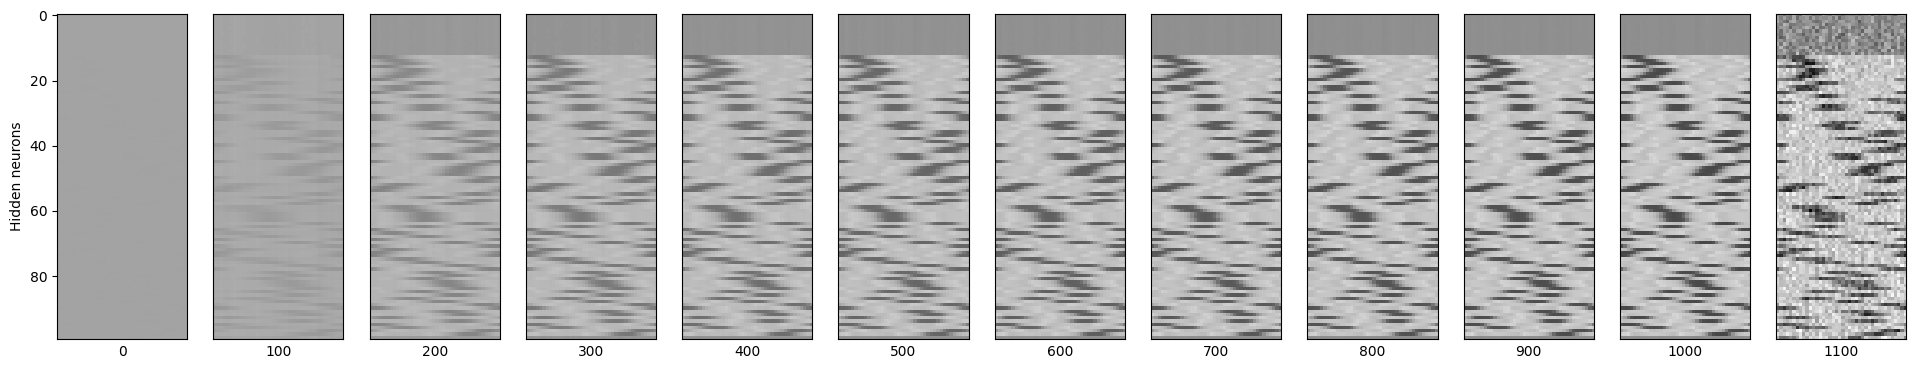

In [36]:
config['init_fn'] = lambda weight_, key, scale: scale * weights[-1]
config['init_scale'] = 1e-2
config['batch_size'] = 100 # bumping up batch size for stability when we make the weights really tiny
config['seed'] = 42 # use a different seed so we make sure this is a general phenomenon
weights_perturbed, metrics_pertrubed = simulate(**config)

w = np.concatenate([weights_perturbed, weights[-1:]])
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)

Using JAX backend: cpu

Using configuration:
{'activation': 'tanh',
 'batch_size': 100,
 'class_proportion': 0.5,
 'dataset_cls': <class 'datasets.single_pulse.SinglePulseDataset'>,
 'gain': None,
 'init_fn': <function <lambda> at 0x157819120>,
 'init_scale': 0.0001,
 'learning_rate': 1.0,
 'model_cls': <class 'models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 100,
 'optimizer_fn': <function sgd at 0x15357efc0>,
 'sampler_cls': <class 'samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 42,
 'wandb_': False,
 'xi1': (0.2, 0.25),
 'xi2': (0.05, 0.1)}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 100000
Length of eval dataset: 2000
Length of train sampler: 100000
Length of eval sampler: 2000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[100,40](numpy),
    bias=None,
    in_features=40,
    out_features=100,
    use_bias=False
  ),
  act=<wrapped function <lambda>>
)

Starting evaluation...
Completed evaluation over 

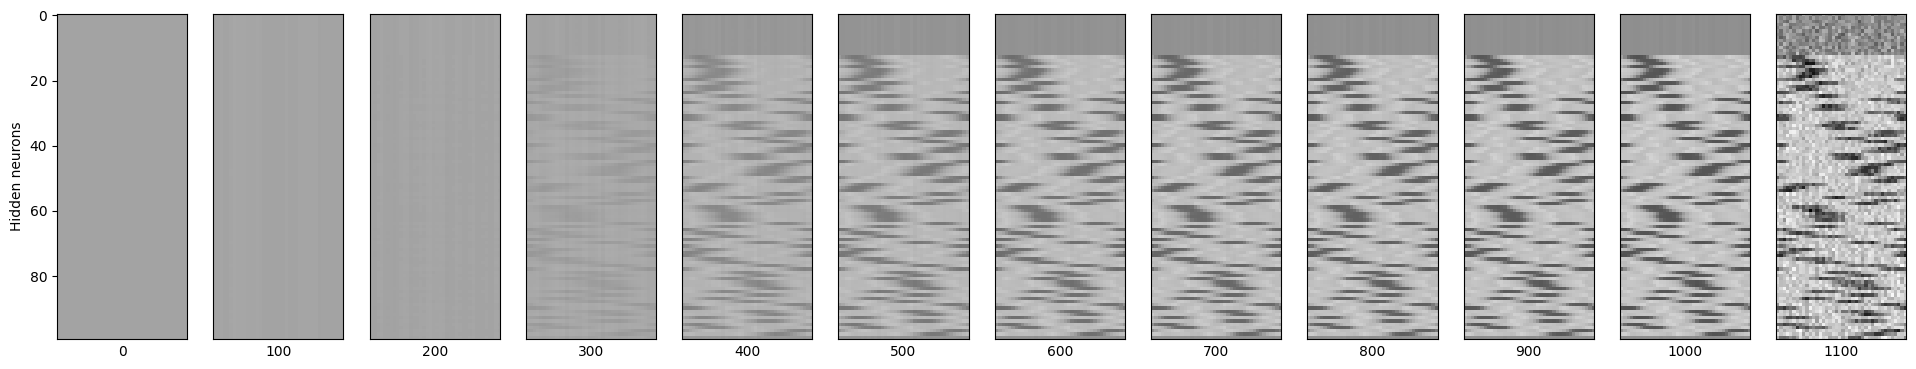

In [37]:
config['init_scale'] = 1e-4
weights_perturbed, metrics_pertrubed = simulate(**config)

w = np.concatenate([weights_perturbed, weights[-1:]])
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)

Using JAX backend: cpu

Using configuration:
{'activation': 'tanh',
 'batch_size': 100,
 'class_proportion': 0.5,
 'dataset_cls': <class 'datasets.single_pulse.SinglePulseDataset'>,
 'gain': None,
 'init_fn': <function <lambda> at 0x157819120>,
 'init_scale': 1e-08,
 'learning_rate': 1.0,
 'model_cls': <class 'models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 100,
 'optimizer_fn': <function sgd at 0x15357efc0>,
 'sampler_cls': <class 'samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 42,
 'wandb_': False,
 'xi1': (0.2, 0.25),
 'xi2': (0.05, 0.1)}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 100000
Length of eval dataset: 2000
Length of train sampler: 100000
Length of eval sampler: 2000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[100,40](numpy),
    bias=None,
    in_features=40,
    out_features=100,
    use_bias=False
  ),
  act=<wrapped function <lambda>>
)

Starting evaluation...
Completed evaluation over 2

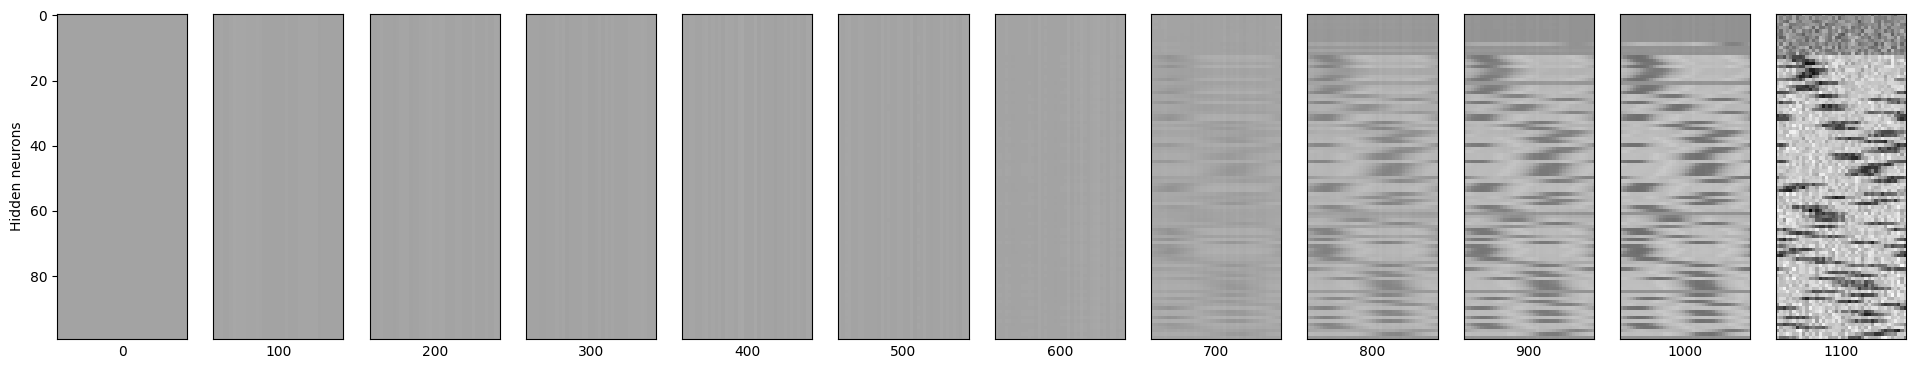

In [38]:
config['init_scale'] = 1e-8
weights_perturbed, metrics_pertrubed = simulate(**config)

w = np.concatenate([weights_perturbed, weights[-1:]])
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)

Using JAX backend: cpu

Using configuration:
{'activation': 'tanh',
 'batch_size': 100,
 'class_proportion': 0.5,
 'dataset_cls': <class 'datasets.single_pulse.SinglePulseDataset'>,
 'gain': None,
 'init_fn': <function <lambda> at 0x157819120>,
 'init_scale': 1e-12,
 'learning_rate': 1.0,
 'model_cls': <class 'models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 100,
 'optimizer_fn': <function sgd at 0x15357efc0>,
 'sampler_cls': <class 'samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 42,
 'wandb_': False,
 'xi1': (0.2, 0.25),
 'xi2': (0.05, 0.1)}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 100000
Length of eval dataset: 2000
Length of train sampler: 100000
Length of eval sampler: 2000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[100,40](numpy),
    bias=None,
    in_features=40,
    out_features=100,
    use_bias=False
  ),
  act=<wrapped function <lambda>>
)

Starting evaluation...
Completed evaluation over 2

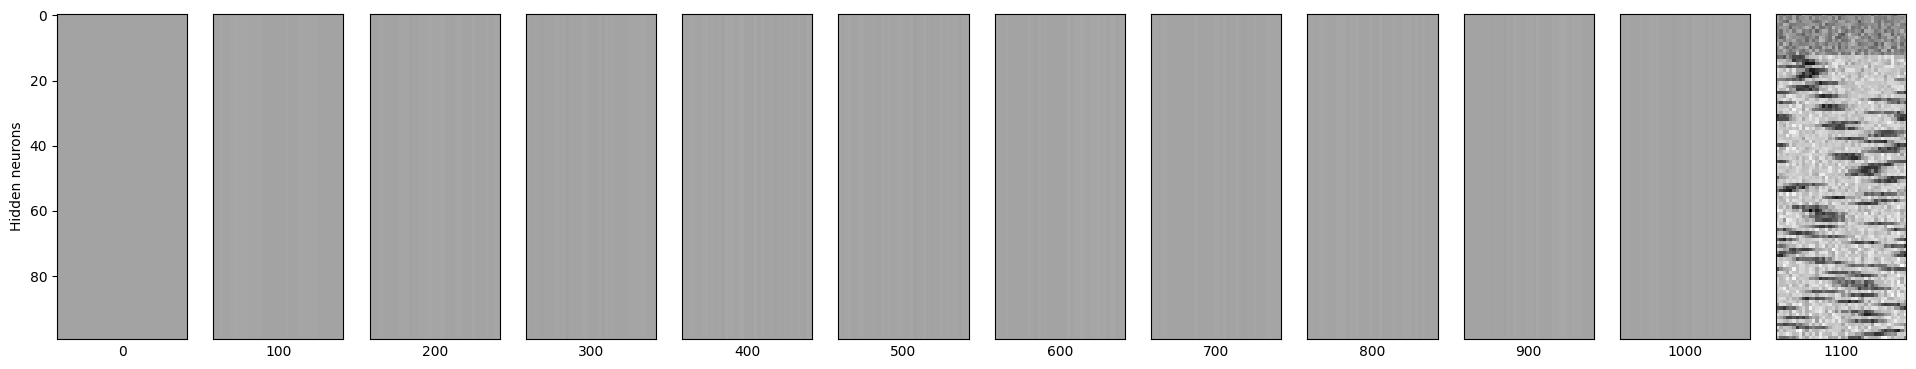

In [39]:
config['init_scale'] = 1e-12
weights_perturbed, metrics_pertrubed = simulate(**config)

w = np.concatenate([weights_perturbed, weights[-1:]])
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)

#### Adding noise

Using JAX backend: cpu

Using configuration:
{'activation': 'tanh',
 'batch_size': 100,
 'class_proportion': 0.5,
 'dataset_cls': <class 'datasets.single_pulse.SinglePulseDataset'>,
 'gain': None,
 'init_fn': <function <lambda> at 0x156fffc40>,
 'init_scale': 0.01,
 'learning_rate': 1.0,
 'model_cls': <class 'models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 100,
 'optimizer_fn': <function sgd at 0x15357efc0>,
 'sampler_cls': <class 'samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 42,
 'wandb_': False,
 'xi1': (0.2, 0.25),
 'xi2': (0.05, 0.1)}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 100000
Length of eval dataset: 2000
Length of train sampler: 100000
Length of eval sampler: 2000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[100,40],
    bias=None,
    in_features=40,
    out_features=100,
    use_bias=False
  ),
  act=<wrapped function <lambda>>
)

Starting evaluation...
Completed evaluation over 2000 exam

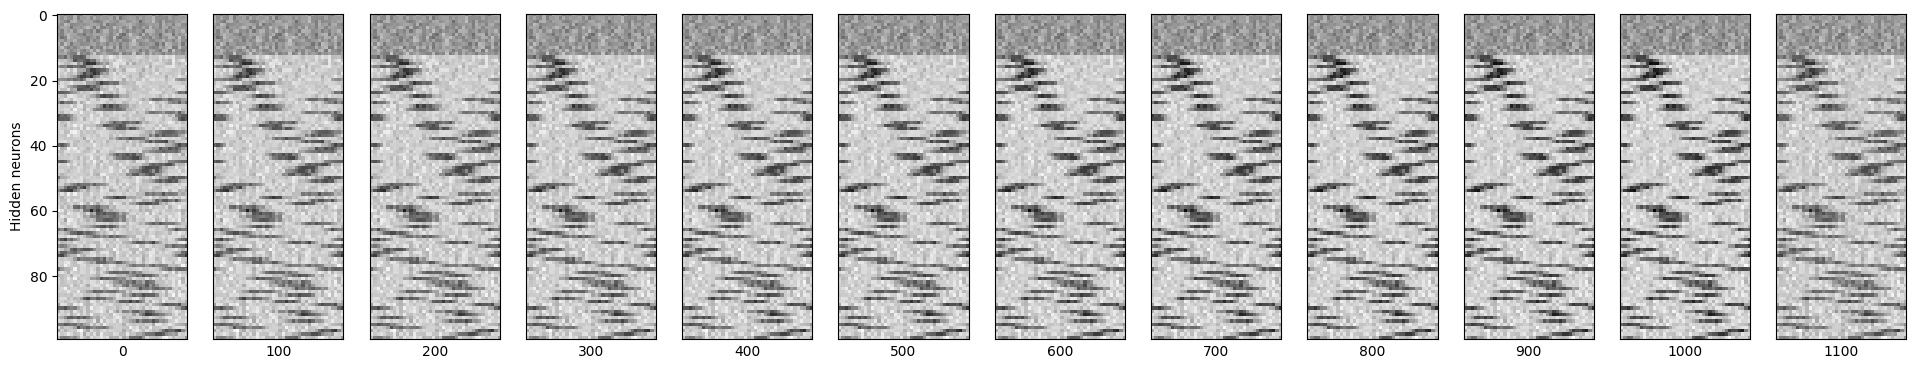

In [40]:
config['init_fn'] = lambda weight_, key, scale: weights[-1] + jax.random.normal(key, shape=weight_.shape) * scale
config['init_scale'] = 1e-2

weights_perturbed, metrics_pertrubed = simulate(**config)

w = np.concatenate([weights_perturbed, weights[-1:]])
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)

Using JAX backend: cpu

Using configuration:
{'activation': 'tanh',
 'batch_size': 100,
 'class_proportion': 0.5,
 'dataset_cls': <class 'datasets.single_pulse.SinglePulseDataset'>,
 'gain': None,
 'init_fn': <function <lambda> at 0x156fffc40>,
 'init_scale': 0.1,
 'learning_rate': 1.0,
 'model_cls': <class 'models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 100,
 'optimizer_fn': <function sgd at 0x15357efc0>,
 'sampler_cls': <class 'samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 42,
 'wandb_': False,
 'xi1': (0.2, 0.25),
 'xi2': (0.05, 0.1)}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 100000
Length of eval dataset: 2000
Length of train sampler: 100000
Length of eval sampler: 2000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[100,40],
    bias=None,
    in_features=40,
    out_features=100,
    use_bias=False
  ),
  act=<wrapped function <lambda>>
)

Starting evaluation...
Completed evaluation over 2000 examp

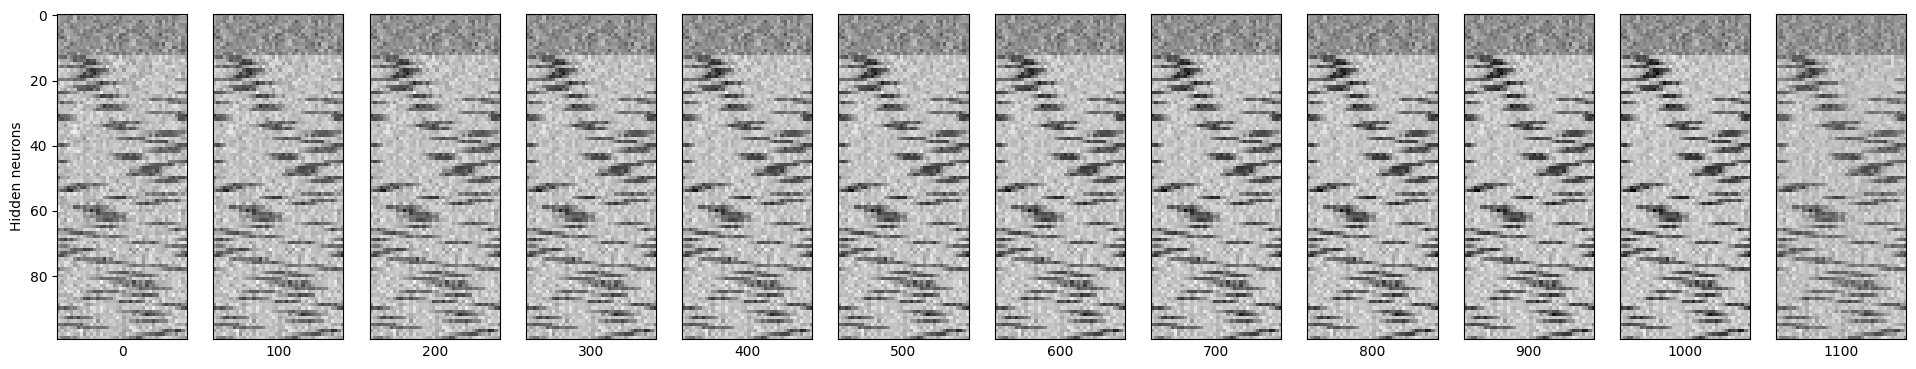

In [41]:
config['init_scale'] = 1e-1

weights_perturbed, metrics_pertrubed = simulate(**config)

w = np.concatenate([weights_perturbed, weights[-1:]])
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)

Using JAX backend: cpu

Using configuration:
{'activation': 'tanh',
 'batch_size': 100,
 'class_proportion': 0.5,
 'dataset_cls': <class 'datasets.single_pulse.SinglePulseDataset'>,
 'gain': None,
 'init_fn': <function <lambda> at 0x156fffc40>,
 'init_scale': 0.5,
 'learning_rate': 1.0,
 'model_cls': <class 'models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 100,
 'optimizer_fn': <function sgd at 0x15357efc0>,
 'sampler_cls': <class 'samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 42,
 'wandb_': False,
 'xi1': (0.2, 0.25),
 'xi2': (0.05, 0.1)}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 100000
Length of eval dataset: 2000
Length of train sampler: 100000
Length of eval sampler: 2000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[100,40],
    bias=None,
    in_features=40,
    out_features=100,
    use_bias=False
  ),
  act=<wrapped function <lambda>>
)

Starting evaluation...
Completed evaluation over 2000 examp

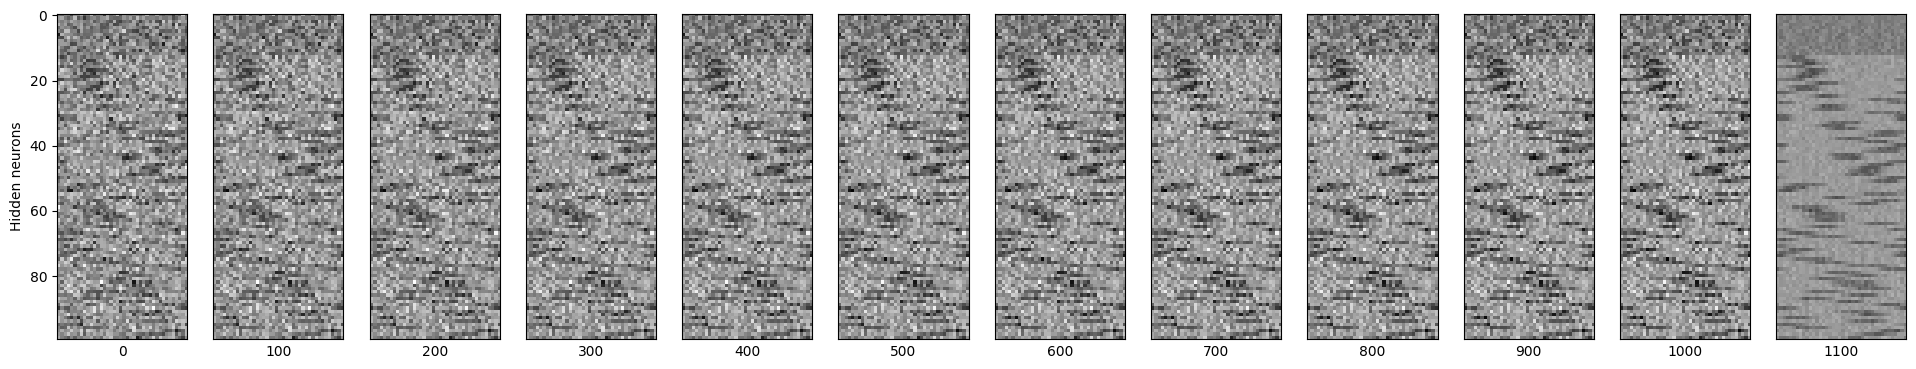

In [42]:
config['init_scale'] = 5e-1

weights_perturbed, metrics_pertrubed = simulate(**config)

w = np.concatenate([weights_perturbed, weights[-1:]])
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)

Using JAX backend: cpu

Using configuration:
{'activation': 'tanh',
 'batch_size': 100,
 'class_proportion': 0.5,
 'dataset_cls': <class 'datasets.single_pulse.SinglePulseDataset'>,
 'gain': None,
 'init_fn': <function <lambda> at 0x156fffc40>,
 'init_scale': 1.0,
 'learning_rate': 1.0,
 'model_cls': <class 'models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 100,
 'optimizer_fn': <function sgd at 0x15357efc0>,
 'sampler_cls': <class 'samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 42,
 'wandb_': False,
 'xi1': (0.2, 0.25),
 'xi2': (0.05, 0.1)}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 100000
Length of eval dataset: 2000
Length of train sampler: 100000
Length of eval sampler: 2000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[100,40],
    bias=None,
    in_features=40,
    out_features=100,
    use_bias=False
  ),
  act=<wrapped function <lambda>>
)

Starting evaluation...
Completed evaluation over 2000 examp

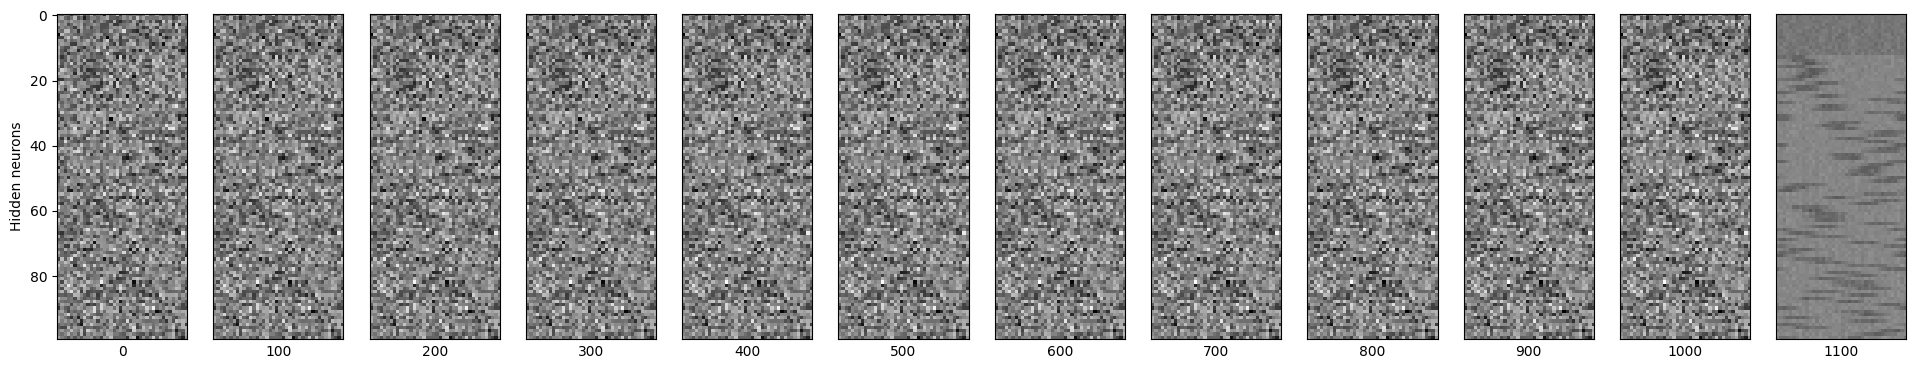

In [43]:
config['init_scale'] = 1.0

weights_perturbed, metrics_pertrubed = simulate(**config)

w = np.concatenate([weights_perturbed, weights[-1:]])
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)

Using JAX backend: cpu

Using configuration:
{'activation': 'tanh',
 'batch_size': 100,
 'class_proportion': 0.5,
 'dataset_cls': <class 'datasets.single_pulse.SinglePulseDataset'>,
 'gain': None,
 'init_fn': <function <lambda> at 0x156fffc40>,
 'init_scale': 2.5,
 'learning_rate': 1.0,
 'model_cls': <class 'models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 100,
 'optimizer_fn': <function sgd at 0x15357efc0>,
 'sampler_cls': <class 'samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 42,
 'wandb_': False,
 'xi1': (0.2, 0.25),
 'xi2': (0.05, 0.1)}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 100000
Length of eval dataset: 2000
Length of train sampler: 100000
Length of eval sampler: 2000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[100,40],
    bias=None,
    in_features=40,
    out_features=100,
    use_bias=False
  ),
  act=<wrapped function <lambda>>
)

Starting evaluation...
Completed evaluation over 2000 examp

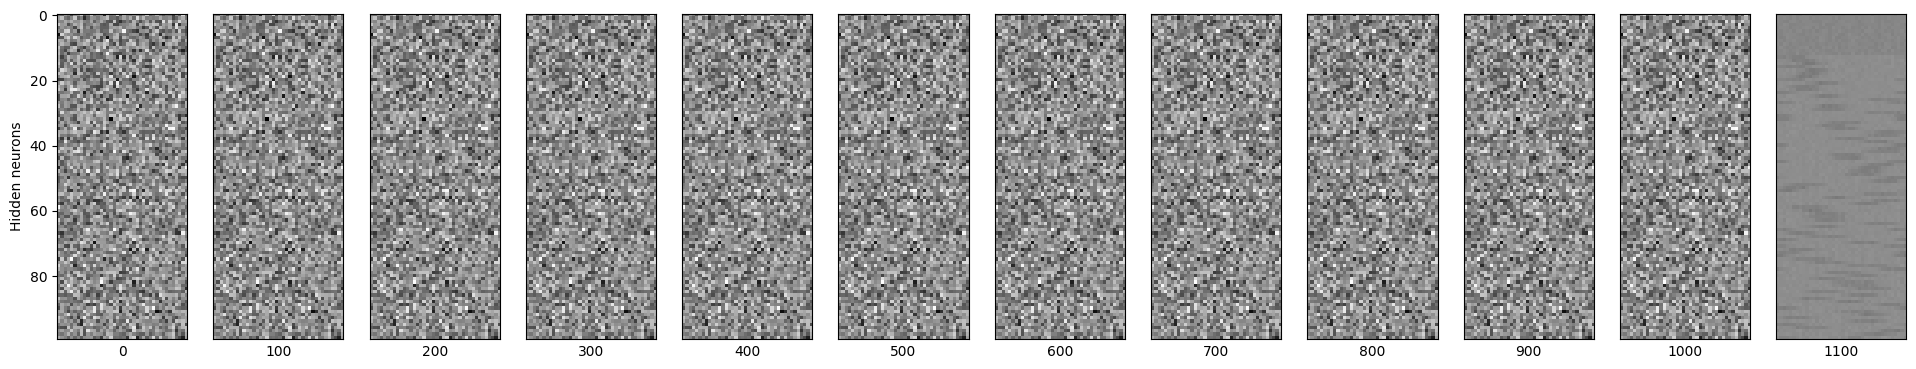

In [44]:
config['init_scale'] = 2.5

weights_perturbed, metrics_pertrubed = simulate(**config)

w = np.concatenate([weights_perturbed, weights[-1:]])
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)

#### Now, we want to understand why a neuron becomes localized or oscillatory.

We'll start by testing to see whether localized and oscillatory neurons are "entangled," or whether they are drawn from different parts of input space.
We'll do this by running two experiments:
1. Resample one class while keeping the other fixed. Do the fixed neurons stay in the same class? What happens to the resampled ones?
2. Given two models, swap the initializations for one class from one model to the other. Do the neurons stay in the same class?

In [ ]:
localized_mask = np.mean(np.abs(weights[-1]), axis=-1) > 0.25
weights_ = weights[0]

We'll see that resampling the oscillatory weights (with perhaps one or two exceptions) does not prevent previously localized weights from again becoming localized (and they learn a similar structure).
Some of the formerly oscillatory weights become localized.
(In fact, it seems to be roughly the same proportion as if we had resampled a larger population of neurons.
This seems to suggest that oscillatory neurons are initialized from a distinct part of the space that is visited with probability $p$.
However, if this were the case, I would expect the fraction of neurons that are oscillatory to be noisier.
Since it seems to robust, perhaps there is something more interesting going on.)

In [56]:
# resample oscillatory weights
key = jax.random.PRNGKey(42)
weights_osc_resampled = np.zeros_like(weights_)
weights_osc_resampled[localized_mask] = weights_[localized_mask]
weights_osc_resampled[~localized_mask] = models.lecun_normal_init(weights_[~localized_mask], key, scale=1.)
config['init_fn'] = lambda weight_, key, scale: scale * weights_osc_resampled
config['init_scale'] = 1.
config['batch_size'] = 1

weights_resampled, metrics_resampled = simulate(**config)

Using JAX backend: cpu

Using configuration:
{'activation': 'tanh',
 'batch_size': 1,
 'class_proportion': 0.5,
 'dataset_cls': <class 'datasets.single_pulse.SinglePulseDataset'>,
 'gain': None,
 'init_fn': <function <lambda> at 0x156614220>,
 'init_scale': 1.0,
 'learning_rate': 1.0,
 'model_cls': <class 'models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 100,
 'optimizer_fn': <function sgd at 0x15357efc0>,
 'sampler_cls': <class 'samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 42,
 'wandb_': False,
 'xi1': (0.2, 0.25),
 'xi2': (0.05, 0.1)}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 1000
Length of eval dataset: 1000
Length of train sampler: 1000
Length of eval sampler: 1000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[100,40](numpy),
    bias=None,
    in_features=40,
    out_features=100,
    use_bias=False
  ),
  act=<wrapped function <lambda>>
)

Starting evaluation...
Completed evaluation over 1000 exam

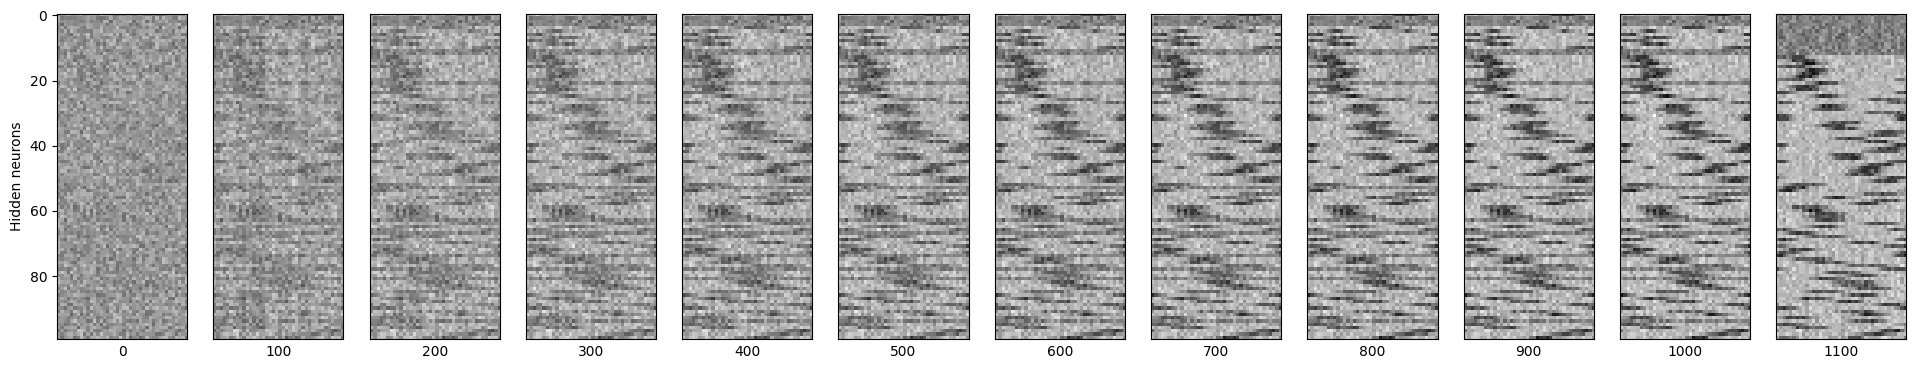

In [57]:
w = np.concatenate([weights_resampled, weights[-1:]])
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)

In [59]:
# same thing, but this time crank up the noise
key = jax.random.PRNGKey(42)
weights_osc_resampled = np.zeros_like(weights_)
weights_osc_resampled[localized_mask] = weights_[localized_mask]
weights_osc_resampled[~localized_mask] = models.lecun_normal_init(weights_[~localized_mask], key, scale=10.)
config['init_fn'] = lambda weight_, key, scale: scale * weights_osc_resampled
config['init_scale'] = 1.
config['batch_size'] = 1

weights_resampled, metrics_resampled = simulate(**config)

Using JAX backend: cpu

Using configuration:
{'activation': 'tanh',
 'batch_size': 1,
 'class_proportion': 0.5,
 'dataset_cls': <class 'datasets.single_pulse.SinglePulseDataset'>,
 'gain': None,
 'init_fn': <function <lambda> at 0x1573b6a20>,
 'init_scale': 1.0,
 'learning_rate': 1.0,
 'model_cls': <class 'models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 100,
 'optimizer_fn': <function sgd at 0x15357efc0>,
 'sampler_cls': <class 'samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 42,
 'wandb_': False,
 'xi1': (0.2, 0.25),
 'xi2': (0.05, 0.1)}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 1000
Length of eval dataset: 1000
Length of train sampler: 1000
Length of eval sampler: 1000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[100,40](numpy),
    bias=None,
    in_features=40,
    out_features=100,
    use_bias=False
  ),
  act=<wrapped function <lambda>>
)

Starting evaluation...
Completed evaluation over 1000 exam

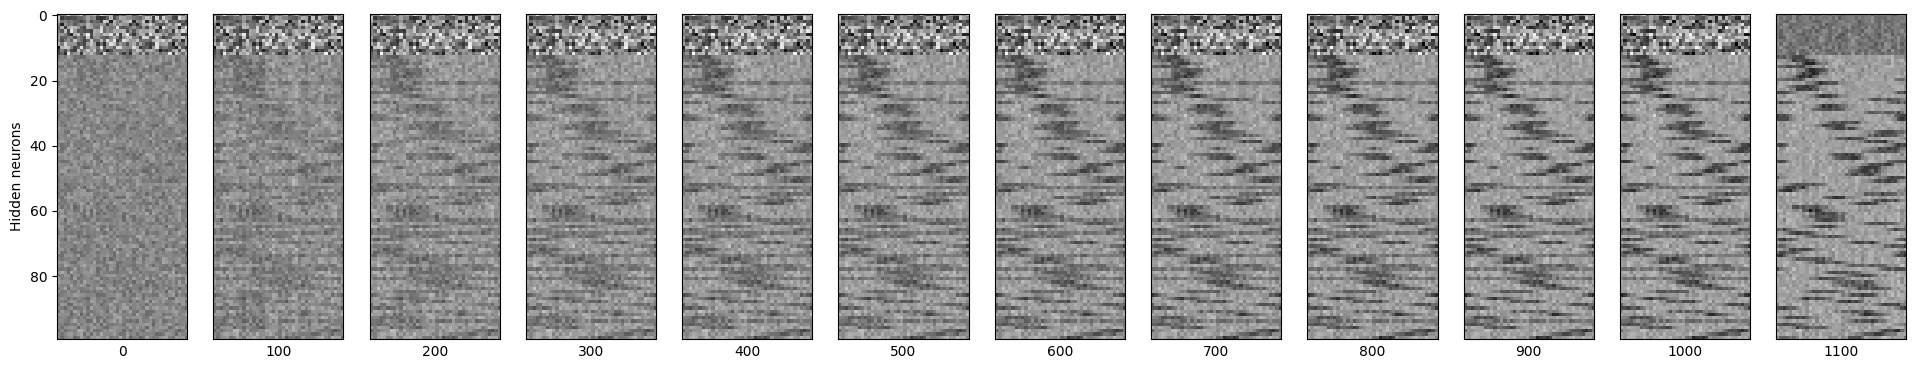

In [60]:
w = np.concatenate([weights_resampled, weights[-1:]])
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)

Now, let's resample the localized weights.

Using JAX backend: cpu

Using configuration:
{'activation': 'tanh',
 'batch_size': 1,
 'class_proportion': 0.5,
 'dataset_cls': <class 'datasets.single_pulse.SinglePulseDataset'>,
 'gain': None,
 'init_fn': <function <lambda> at 0x157cb3100>,
 'init_scale': 1.0,
 'learning_rate': 1.0,
 'model_cls': <class 'models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 100,
 'optimizer_fn': <function sgd at 0x15357efc0>,
 'sampler_cls': <class 'samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 42,
 'wandb_': False,
 'xi1': (0.2, 0.25),
 'xi2': (0.05, 0.1)}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 1000
Length of eval dataset: 1000
Length of train sampler: 1000
Length of eval sampler: 1000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[100,40](numpy),
    bias=None,
    in_features=40,
    out_features=100,
    use_bias=False
  ),
  act=<wrapped function <lambda>>
)

Starting evaluation...
Completed evaluation over 1000 exam

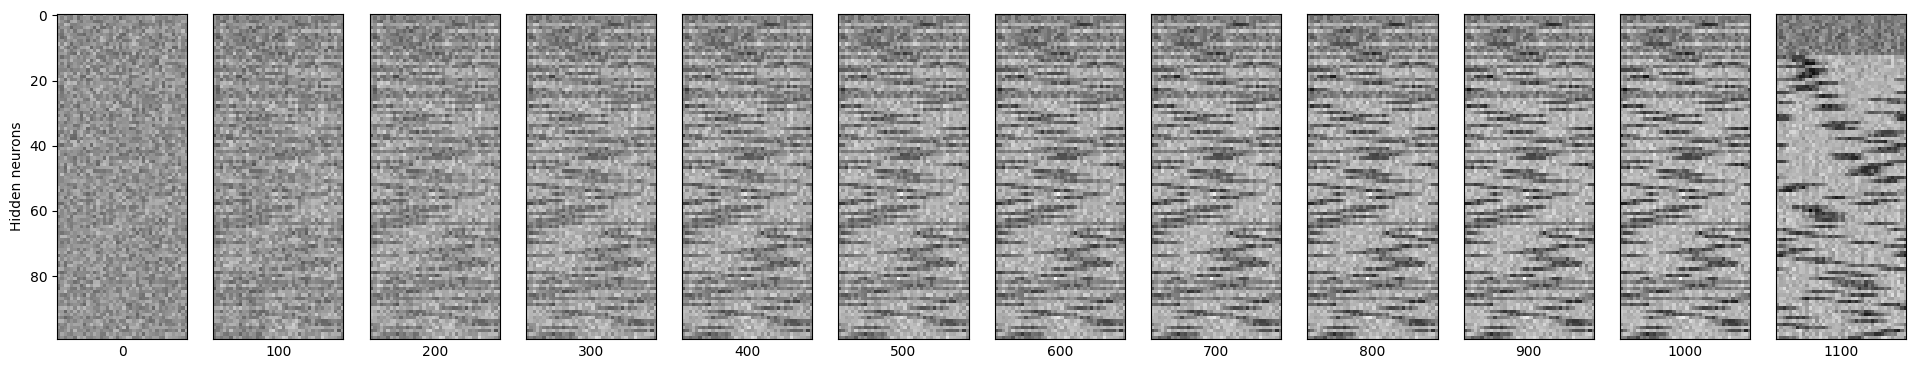

In [61]:
# resample localized weights
key = jax.random.PRNGKey(42)
weights_loc_resampled = np.zeros_like(weights_)
weights_loc_resampled[~localized_mask] = weights_[~localized_mask]
weights_loc_resampled[localized_mask] = models.lecun_normal_init(weights_[localized_mask], key, scale=1.)
config['init_fn'] = lambda weight_, key, scale: scale * weights_loc_resampled
config['init_scale'] = 1.
config['batch_size'] = 1

weights_resampled, metrics_resampled = simulate(**config)
w = np.concatenate([weights_resampled, weights[-1:]])

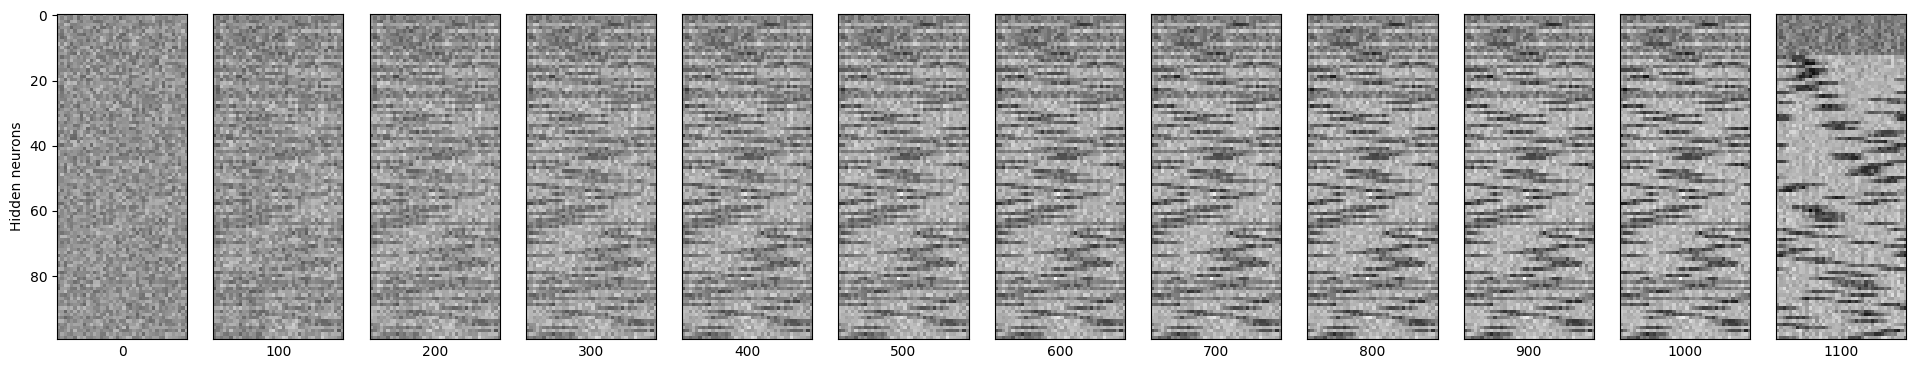

In [62]:
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)

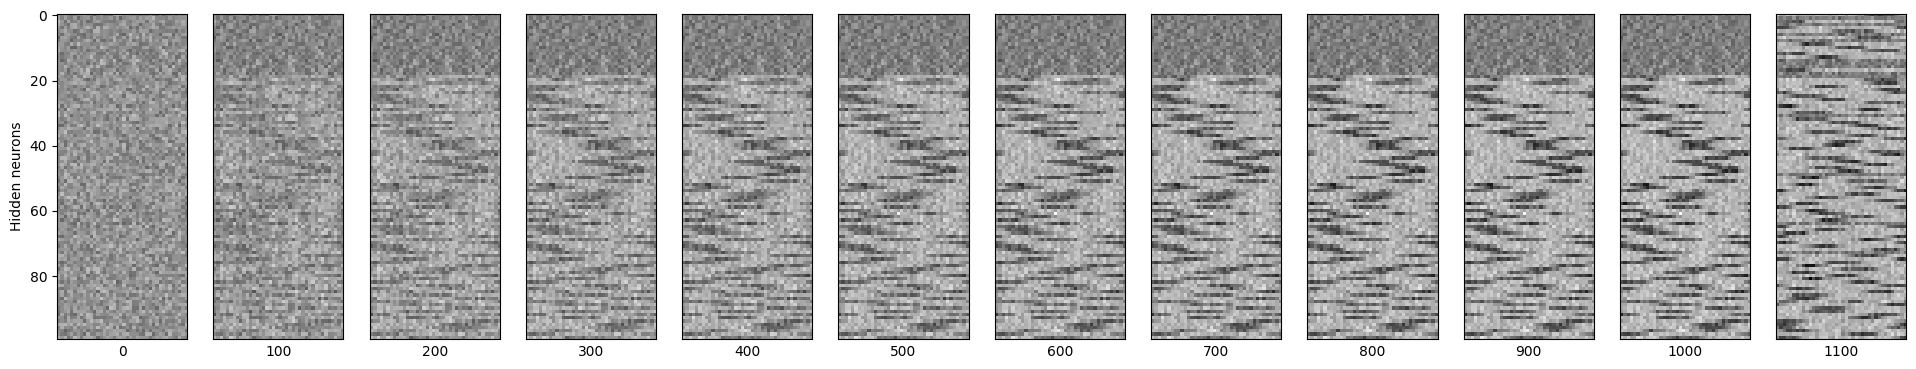

In [63]:
fig, axs = plot_receptive_fields(w, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-2, center_sort=True, evaluation_interval=evaluation_interval)